In [1]:
!pip install Pillow
!pip install rasterio
!pip install segmentation_models
!pip install mat4py
!apt install octave

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 46.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 229.2 kB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  aglfn epstool fonts-droid-fallback fonts-freefont-otf fonts-noto-mono
  fonts-urw-base35 ghostscript gnuplot-data gnuplot-qt gsfonts
  imagemagick-6-common 

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import tensorflow as tf
import cv2
import os,re
import rasterio
from random import randint
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rasterio.plot import show, show_hist
from keras.layers import Input
from sklearn.model_selection import train_test_split
import sys,traceback
from mat4py import savemat

Mounted at /content/drive


In [3]:
tifpath = "/content/drive/My Drive/dataset/images/"
bmppath = "/content/drive/My Drive/dataset/mask/"
bmpfol = []
tiffol=[]
for image in os.listdir(tifpath):
    tiffol.append(image)
for _ in os.listdir(bmppath):
  bmpfol.append(_)


#To change between images, change from here


bmpd = bmppath + bmpfol[1]
tifd = tifpath + tiffol[1]
print("Sample .bmp file directory:\n",bmpd)
print('\nInstances of Mask Dataset:',len(bmpfol))
print('\nInstances of Raster Image Dataset:',len(tiffol))

Sample .bmp file directory:
 /content/drive/My Drive/dataset/mask/time-20192422210192-loc--119.2_37.6_-118.28_38.8.bmp

Instances of Mask Dataset: 352

Instances of Raster Image Dataset: 352


In [4]:
srb = rasterio.open(bmpd)
#Rasterio Color Interpretation of .bmp Image
print("Rasterio Colormap object created for .bmp file:\n",srb.colormap,"\n\nRasterio ColorInterp object created for .bmp file:\n",srb.colorinterp)

Rasterio Colormap object created for .bmp file:
 <built-in method colormap of DatasetReader object at 0x7fd79ccd7240> 

Rasterio ColorInterp object created for .bmp file:
 (<ColorInterp.palette: 2>,)


/usr/local/lib/python3.8/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Width:66, Height:110



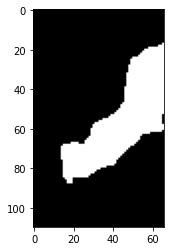

In [5]:
plt.imshow(srb.read(1), cmap='gray')
print(f"Width:{srb.width}, Height:{srb.height}\n")
plt.show()

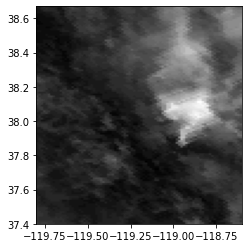

(<ColorInterp.gray: 1>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>)
<built-in method colormap of DatasetReader object at 0x7fd79ccd7340>


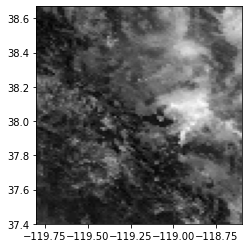

(<ColorInterp.gray: 1>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>)
<built-in method colormap of DatasetReader object at 0x7fd79ccd7340>


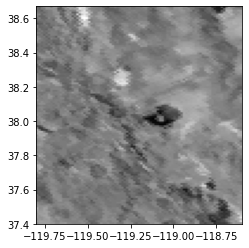

(<ColorInterp.gray: 1>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>)
<built-in method colormap of DatasetReader object at 0x7fd79ccd7340>


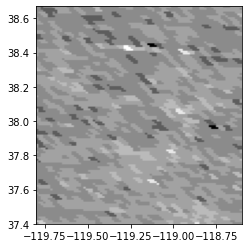

(<ColorInterp.gray: 1>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>)
<built-in method colormap of DatasetReader object at 0x7fd79ccd7340>


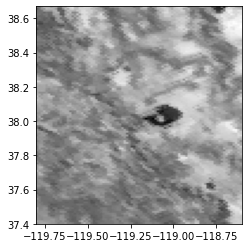

(<ColorInterp.gray: 1>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>)
<built-in method colormap of DatasetReader object at 0x7fd79ccd7340>


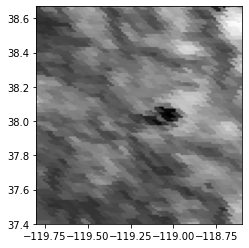

(<ColorInterp.gray: 1>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>)
<built-in method colormap of DatasetReader object at 0x7fd79ccd7340>


In [6]:
srt = rasterio.open(tifd)
for _ in range(1,7):
  try:
    show(srt.read(_),transform=srt.transform,cmap='gray')
    print(srt.colorinterp)
    print(srt.colormap)
  except IndexError:
    break

In [7]:
srt.descriptions #No descriptions given on the rasters

(None, None, None, None, None, None)

In [8]:
path = tifpath + '/' + tiffol[1]
with rasterio.open(path) as src:
    tifa = src.read()
    meta = src.meta
    #Tagged Raster Image into N-Dimensional Array
    print("Matrix Representation of .tif image:\n")
    print(tifa,"\n\nDatatype:",tifa.dtype)

Matrix Representation of .tif image:

[[[57 57 59 ... 69 68 68]
  [56 57 59 ... 71 70 70]
  [56 56 57 ... 72 72 72]
  ...
  [61 60 60 ... 64 64 63]
  [61 61 61 ... 64 64 61]
  [62 61 62 ... 65 65 64]]

 [[38 40 45 ... 58 56 56]
  [37 38 40 ... 59 60 59]
  [36 39 38 ... 62 68 65]
  ...
  [40 41 40 ... 56 53 48]
  [48 42 41 ... 57 59 48]
  [42 43 45 ... 58 56 54]]

 [[56 56 63 ... 61 59 59]
  [61 56 63 ... 66 66 65]
  [59 59 55 ... 70 74 74]
  ...
  [70 73 71 ... 79 79 85]
  [74 76 76 ... 71 79 97]
  [69 75 75 ... 72 72 72]]

 [[ 7  7  5 ...  8  8  8]
  [ 7  7  5 ...  8  8  7]
  [ 7  7  7 ...  8  8  8]
  ...
  [ 7  7  8 ...  8  8  8]
  [10 10 10 ...  8  8  8]
  [ 7 10 10 ...  7  7  7]]

 [[43 43 54 ... 62 59 59]
  [35 43 54 ... 69 67 66]
  [41 41 43 ... 73 77 77]
  ...
  [51 51 49 ... 71 71 69]
  [59 57 57 ... 69 71 70]
  [53 57 58 ... 71 71 70]]

 [[31 31 43 ... 63 52 52]
  [31 31 43 ... 65 65 58]
  [31 31 31 ... 65 65 65]
  ...
  [35 35 35 ... 56 56 56]
  [39 39 39 ... 52 56 56]
  [39 

In [9]:
print("Matrix Representation of .bmp file\n")
bmpa = np.array(srb.read(1))
#Bitmap Image into N-Dimensional array
print(bmpa,"\n\nDatatype:",bmpa.dtype)

Matrix Representation of .bmp file

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] 

Datatype: uint8


In [10]:
meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 87,
 'height': 117,
 'count': 6,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.013793103448275895, 0.0, -119.8,
        0.0, -0.010854700854700881, 38.67)}

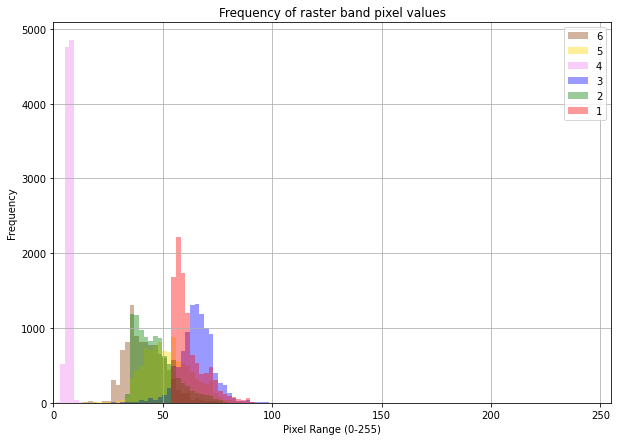

In [11]:
(axrgb, axhist) = plt.subplots(1, 1, figsize=(10,7))
show_hist(
    tifa, bins=50, lw=0.0, stacked=False, alpha=0.4,
    histtype='stepfilled', title="Histogram",ax=axhist)
plt.xlim(xmin=0, xmax = 255)
axhist.set_xlabel('Pixel Range (0-255)')
axhist.set_title("Frequency of raster band pixel values")
plt.show()

The fourth raster seems to stand out from the other five rasters and the first raster also shows some level of promise.

In [ ]:
#Should we identify "Normalized Difference Haze Index"?

In [ ]:
#Upload nasameta.m and show the .tif image's description
savemat("nasameta.m",tifd)

ValueError: ignored

In [ ]:
!octave -W nasameta.m

error: 'tifd' undefined near line 1 column 8
error: called from
    nasameta at line 1 column 7


In [12]:
print("Dimensions of .tif image:",tifa.shape)
print("\nMetadata:\n",meta)

Dimensions of .tif image: (6, 117, 87)

Metadata:
 {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 87, 'height': 117, 'count': 6, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.013793103448275895, 0.0, -119.8,
       0.0, -0.010854700854700881, 38.67)}


In [13]:
print("Dimensions of .bmp image:",bmpa.shape)

Dimensions of .bmp image: (110, 66)


In [14]:
Y = []
for path in bmpfol:
  imgy = cv2.imread(os.path.join(bmppath,path))
  Y.append(imgy)

In [ ]:
X = []
for path in tiffol:
  with rasterio.open(os.path.join(tifpath,path)) as srt:
    imgx = srt.read()
    print("Raster Image Metadata",srt.meta,'\n')
  X.append(imgx)

In [ ]:
for i in range(0,len(X)):
  print("Shape of Raster Image:",X[i].shape,"\n")
  print("Shape of Mask Image",Y[i].shape,'\n')

In [29]:
rastcols = ['TiffHeight','TiffWidth','BmpHeight','BmpWidth']
rastframe = pd.DataFrame(columns = rastcols)
for i in range(0,len(X)):
    rastframe.loc[len(rastframe.index)]=[X[i].shape[1],X[i].shape[2],Y[i].shape[0],Y[i].shape[1]]
rastframe

,TiffHeight,TiffWidth,BmpHeight,BmpWidth
0,110,66,117,87
1,117,87,110,66
2,161,124,120,169
3,92,68,305,135
4,386,231,120,126
...,...,...,...,...
347,83,82,83,82
348,231,167,231,167
349,55,47,55,47
350,46,52,46,52


In [50]:
rastframe.loc[:,['TiffHeight','TiffWidth']].value_counts

<bound method DataFrame.value_counts of     TiffHeight TiffWidth
0          110        66
1          117        87
2          161       124
3           92        68
4          386       231
..         ...       ...
347         83        82
348        231       167
349         55        47
350         46        52
351        397       352

[352 rows x 2 columns]>

In [48]:
rastframe.loc[:,['BmpHeight','BmpWidth']].value_counts

<bound method DataFrame.value_counts of     BmpHeight BmpWidth
0         117       87
1         110       66
2         120      169
3         305      135
4         120      126
..        ...      ...
347        83       82
348       231      167
349        55       47
350        46       52
351       397      352

[352 rows x 2 columns]>

This means there is no common pattern of pixel dimensions in the images.

In [ ]:
#just in case scaling function
def scale_resize_image(image):
    image = tf.image.convert_image_dtype(image, tf.float32) # equivalent to dividing image pixels by 255
    image = tf.image.resize(image, (224, 224)) # Resizing the image to 224x224 dimention
    return image

# Ideas
Do we need to scale the images? Do we need to try a different model? Padding?? Change the Strides??


In [ ]:
#U-Net Model
try:
    inputs = tf.keras.layers.Input((6, 512, 512))
    s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)
    #Contraction Path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
    
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
    
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
    
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansion Path 
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    
    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    
    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(3, (1, 1), activation='softmax')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
except Exception as e:
    exc_type, exc_obj, exc_tb = sys.exc_info()
    ble = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
    print(exc_type, ble,"\n\nFound at Line",exc_tb.tb_lineno)
    print("\n\n⚠ ⚠ ⚠ ⚠\n\n",traceback.format_exc(),"\n⚠ ⚠ ⚠ ⚠")

<class 'ValueError'> <ipython-input-23-fc995e99c5b6> 

Found at Line 19


⚠ ⚠ ⚠ ⚠

 Traceback (most recent call last):
  File "<ipython-input-23-fc995e99c5b6>", line 19, in <module>
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
  File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/ops.py", line 1967, in _create_c_op
    raise ValueError(e.message)
ValueError: Exception encountered when calling layer "max_pooling2d_2" (type MaxPooling2D).

Negative dimension size caused by subtracting 2 from 1 for '{{node max_pooling2d_2/MaxPool}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1]](Placeholder)' with input shapes: [?,1,128,64].

Call arguments received by layer "max_pooling2d_2" (type MaxPooling2D):
  • inputs=tf.Tensor(shape=(None, 1, 128

In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from keras.models import Model

# Input layer
inputs = Input((512, 512, 6))

# Encoder section
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

# Bottleneck
conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)

# Decoder section
up1 = UpSampling2D(size=(2, 2))(conv4)
merge1 = concatenate([conv3, up1], axis=-1)
conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge1)
up2 = UpSampling2D(size=(2, 2))(conv5)
merge2 = concatenate([conv2, up2], axis=-1)
conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge2)
up3 = UpSampling2D(size=(2, 2))(conv6)
merge3 = concatenate([conv1, up3], axis=-1)
conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge3)

# Output layer
outputs = Conv2D(3, (1, 1), activation='softmax')(conv7)

# Create the model
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 6  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 512, 512, 64  3520        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 256, 256, 64  0          ['conv2d_6[0][0]']               
                                )                                                             

In [ ]:
xtrain,xtest,ytrain,ytest=train_test_split(X,Y,test_size=0.2,random_state=5)

In [ ]:
model.fit(xtrain,ytrain)
#Data Cardinality is Ambiguous